In [6]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [7]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [16]:
path = '/Volumes/HARDDRIVE/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [17]:
Y.scp_codes.head()

ecg_id
1    {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                {'NORM': 80.0, 'SBRAD': 0.0}
3                  {'NORM': 100.0, 'SR': 0.0}
4                  {'NORM': 100.0, 'SR': 0.0}
5                  {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, dtype: object

In [18]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [19]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [20]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test


In [21]:
Y[['scp_codes','diagnostic_superclass']]

,scp_codes,diagnostic_superclass
ecg_id,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",[NORM]
2,"{'NORM': 80.0, 'SBRAD': 0.0}",[NORM]
3,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
4,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
5,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",[STTC]
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",[NORM]
21835,"{'ISCAS': 50.0, 'SR': 0.0}",[STTC]


In [22]:
# convert list to a string
Y['diagnosis_combined'] = Y['diagnostic_superclass'].apply(lambda x: ' '.join(x))

Y[['diagnosis_combined','diagnostic_superclass']]
print(Y['diagnosis_combined'].nunique())

27


In [23]:
print(Y['diagnosis_combined'].value_counts())

diagnosis_combined
NORM              9069
MI                2532
STTC              2400
CD                1708
CD MI             1297
STTC HYP           781
STTC MI            599
HYP                535
                   411
NORM CD            407
STTC MI HYP        361
CD HYP             300
STTC CD            270
CD STTC            201
MI HYP             183
CD STTC HYP        127
STTC CD MI         118
CD MI HYP          117
CD STTC MI         105
CD STTC MI HYP     103
STTC CD HYP         84
STTC CD MI HYP      53
NORM STTC           28
NORM CD STTC         5
NORM CD HYP          2
NORM HYP             2
NORM CD MI HYP       1
Name: count, dtype: int64


In [24]:
# Split into train and test. 

test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [25]:
print(X.shape)

(21799, 1000, 12)


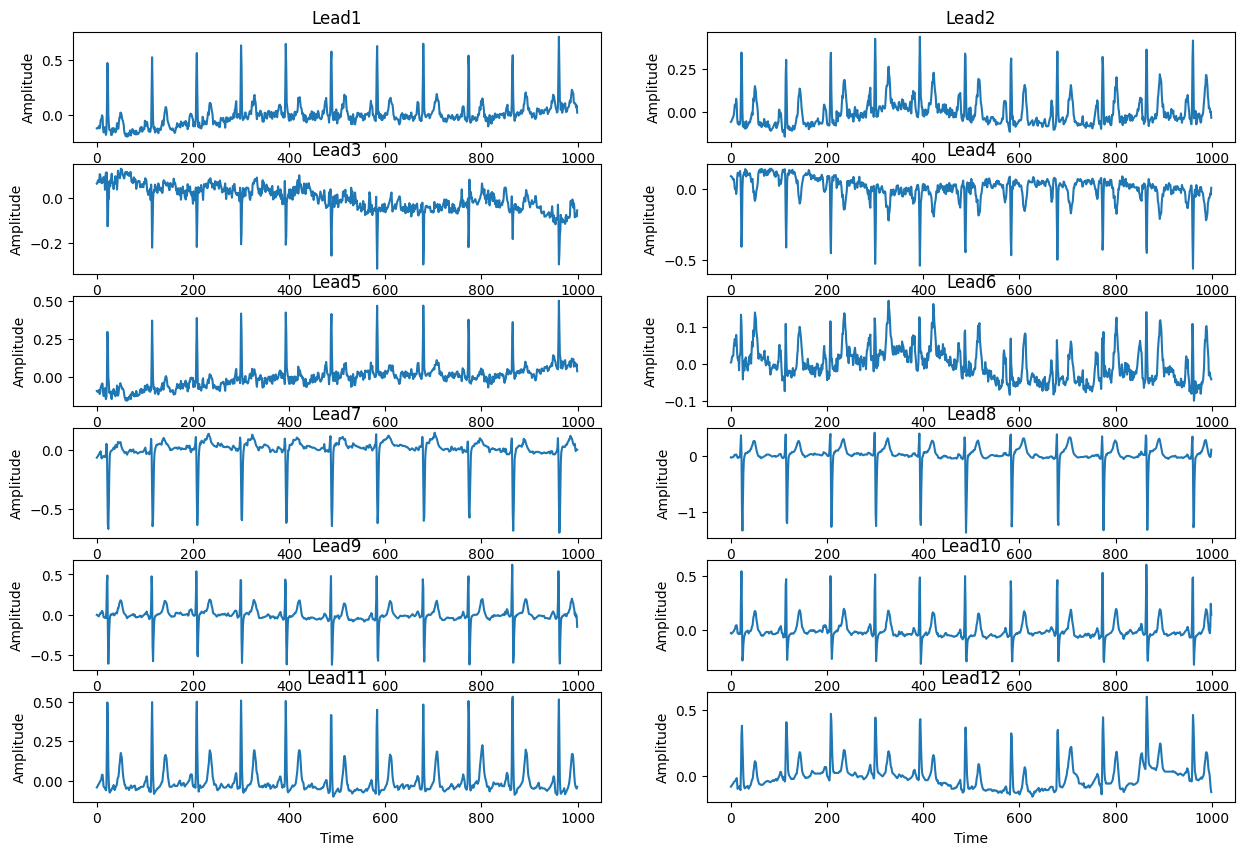

In [26]:
import matplotlib.pyplot as plt
idx = 0
ecg_signal = X[idx]

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.plot(ecg_signal[:,i])
    plt.title(f'Lead{i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude') 

plt.show()

In [39]:
print(X[0])
print(X[0].shape)

[[-0.119 -0.055  0.064 ... -0.026 -0.039 -0.079]
 [-0.116 -0.051  0.065 ... -0.031 -0.034 -0.074]
 [-0.12  -0.044  0.076 ... -0.028 -0.029 -0.069]
 ...
 [ 0.069  0.    -0.069 ...  0.024 -0.041 -0.058]
 [ 0.086  0.004 -0.081 ...  0.242 -0.046 -0.098]
 [ 0.022 -0.031 -0.054 ...  0.143 -0.035 -0.12 ]]
(1000, 12)


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

## Change the labels using binarization

In [31]:
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_test_bin = mlb.transform(y_test)

print(mlb.classes_) 

['CD' 'HYP' 'MI' 'NORM' 'STTC']


## Normalize the signals

In [32]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train = X_train / np.max(np.abs(X_train), axis=(1, 2), keepdims=True)
X_test = X_test / np.max(np.abs(X_test), axis=(1, 2), keepdims=True)

## Define the manual CNN model

In [33]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (1000, 12)

model = Sequential([
    Conv1D(32, kernel_size=7, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(mlb.classes_), activation='sigmoid')  # sigmoid for multilabel
])

/Users/grealish/anaconda3/envs/cnn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # multilabel = binary_crossentropy
              metrics=['accuracy'])

## Training the Model

In [35]:
history = model.fit(X_train, y_train_bin,
                    validation_data=(X_test, y_test_bin),
                    epochs=10,
                    batch_size=64)

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 67s 186ms/step - accuracy: 0.5072 - loss: 0.4582 - val_accuracy: 0.4227 - val_loss: 1.1197
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - accuracy: 0.6396 - loss: 0.3445 - val_accuracy: 0.6051 - val_loss: 0.3892
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.6639 - loss: 0.3177 - val_accuracy: 0.6447 - val_loss: 0.3144
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.6678 - loss: 0.3027 - val_accuracy: 0.6397 - val_loss: 0.3437
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.6770 - loss: 0.2939 - val_accuracy: 0.6783 - val_loss: 0.3148
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.6728 - loss: 0.2941 - val_accuracy: 0.6793 - val_loss: 0.2992
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.6756 - loss: 0.2856 - val_accuracy: 0.6597 - val_loss: 0.3174
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.6882 - loss: 0

In [36]:
loss, acc = model.evaluate(X_test, y_test_bin)
print(f'Test Accuracy: {acc:.4f}')

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6796 - loss: 0.2968
Test Accuracy: 0.6633


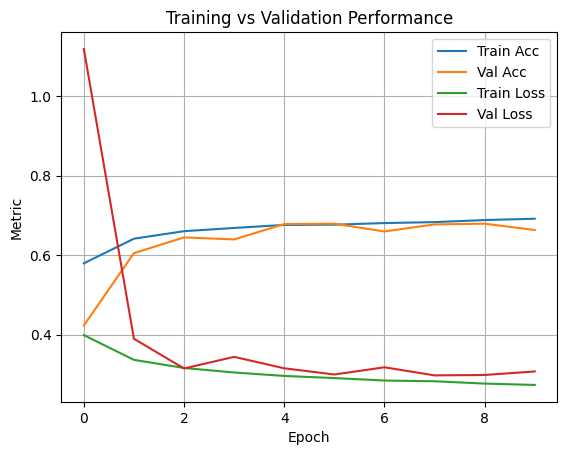

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.show()

The manually coded CNN generated a test accuracy of 68% 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train_bin,
          validation_data=(X_test, y_test_bin),
          epochs=30,
          batch_size=64,
          callbacks=[early_stop])

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6922 - loss: 0.2697 - val_accuracy: 0.6711 - val_loss: 0.2958
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7003 - loss: 0.2670 - val_accuracy: 0.6570 - val_loss: 0.3000
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6973 - loss: 0.2619 - val_accuracy: 0.6688 - val_loss: 0.2894
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6922 - loss: 0.2620 - val_accuracy: 0.6838 - val_loss: 0.2863
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7048 - loss: 0.2540 - val_accuracy: 0.6788 - val_loss: 0.3005
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7062 - loss: 0.2586 - val_accuracy: 0.6679 - val_loss: 0.3050
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7039 - loss: 0.2554 - val_accuracy: 0.6656 - val_loss: 0.3177


After running more epochs, the results don't particularly improve. The validation accuracy remains at around .67

## Tweaking the CNN model

### Higher Dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) 

drop_model = Sequential([
    Conv1D(32, kernel_size=7, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2), 

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2), 

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dropout(0.7),  
    Dense(64, activation='relu'),
    Dense(len(mlb.classes_), activation='sigmoid')  
])

c:\Users\gkim296\AppData\Local\anaconda3\envs\cnn\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
drop_model.compile(optimizer="adam",
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy']

)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

drop_history = drop_model.fit(X_train, y_train_bin,
                    validation_data=(X_test, y_test_bin),
                    epochs=30,
                    batch_size=64,
                    callbacks=[early_stop])

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4923 - loss: 0.4839 - val_accuracy: 0.4172 - val_loss: 0.8687
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6210 - loss: 0.3644 - val_accuracy: 0.5337 - val_loss: 0.4938
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6366 - loss: 0.3414 - val_accuracy: 0.6106 - val_loss: 0.3498
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6480 - loss: 0.3296 - val_accuracy: 0.6297 - val_loss: 0.3479
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6642 - loss: 0.3135 - val_accuracy: 0.6224 - val_loss: 0.3662
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6625 - loss: 0.3096 - val_accuracy: 0.6278 - val_loss: 0.3541
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6679 - loss: 0.3072 - val_accuracy: 0.6497 - val_loss: 0.3352
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6718 - loss: 0.3016 - val

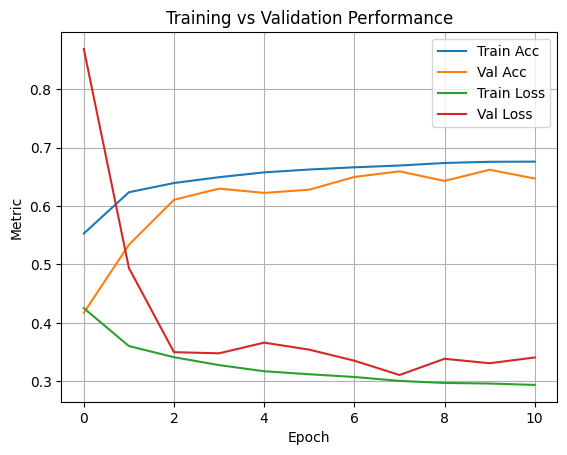

In [ ]:
import matplotlib.pyplot as plt

plt.plot(drop_history.history['accuracy'], label='Train Acc')
plt.plot(drop_history.history['val_accuracy'], label='Val Acc')
plt.plot(drop_history.history['loss'], label='Train Loss')
plt.plot(drop_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.show()

### Regularization

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

l2_strength = 0.001


input_shape = (X_train.shape[1], X_train.shape[2])  

reg_model = Sequential([
    Conv1D(32, kernel_size=7, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength),
           input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength)),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [ ]:
reg_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_reg = reg_model.fit(X_train, y_train_bin,
                            validation_data=(X_test, y_test_bin),
                            epochs=20,
                            batch_size=64,
                            callbacks=[early_stop])

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5388 - loss: 0.6437 - val_accuracy: 0.4199 - val_loss: 0.7281
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6477 - loss: 0.4225 - val_accuracy: 0.6060 - val_loss: 0.4395
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6606 - loss: 0.3722 - val_accuracy: 0.6620 - val_loss: 0.3817
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6690 - loss: 0.3497 - val_accuracy: 0.6697 - val_loss: 0.3579
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6732 - loss: 0.3377 - val_accuracy: 0.6761 - val_loss: 0.3557
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6771 - loss: 0.3314 - val_accuracy: 0.6397 - val_loss: 0.3738
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6777 - loss: 0.3259 - val_accuracy: 0.6492 - val_loss: 0.3451
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6788 - loss: 0.3241 - val_accu

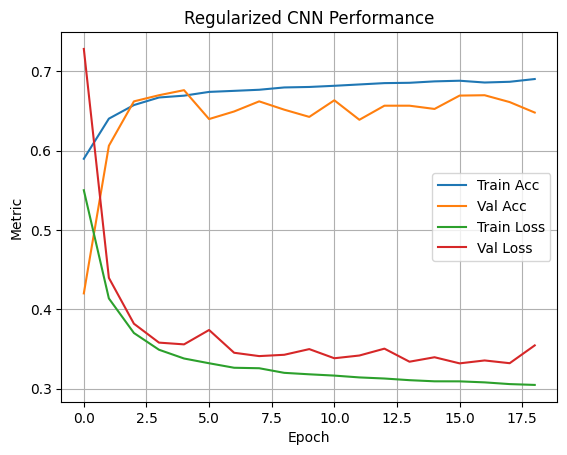

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_reg.history['accuracy'], label='Train Acc')
plt.plot(history_reg.history['val_accuracy'], label='Val Acc')
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title("Regularized CNN Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.show()

### Combination of different techniques

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

l2_strength = 0.001

input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (1000, 12)

final_model = Sequential([
    Conv1D(32, kernel_size=7, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength),
           input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=5, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(128, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(l2_strength)),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
    Dense(len(mlb.classes_), activation='sigmoid')
])



In [ ]:
final_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

lr_schedule = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=2,
                                verbose=1,
                                min_lr=1e-6)

In [ ]:
history_final = final_model.fit(X_train, y_train_bin,
                                validation_data=(X_test, y_test_bin),
                                epochs=30,
                                batch_size=64,
                                callbacks=[early_stop, lr_schedule])

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5322 - loss: 0.6482 - val_accuracy: 0.4167 - val_loss: 1.4543 - learning_rate: 0.0010
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6174 - loss: 0.4374 - val_accuracy: 0.4722 - val_loss: 0.7299 - learning_rate: 0.0010
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6337 - loss: 0.3861 - val_accuracy: 0.6160 - val_loss: 0.4172 - learning_rate: 0.0010
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6559 - loss: 0.3625 - val_accuracy: 0.6465 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6565 - loss: 0.3512 - val_accuracy: 0.6283 - val_loss: 0.3960 - learning_rate: 0.0010
Epoch 6/30
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6607 - loss: 0.3421
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6607 - loss: 

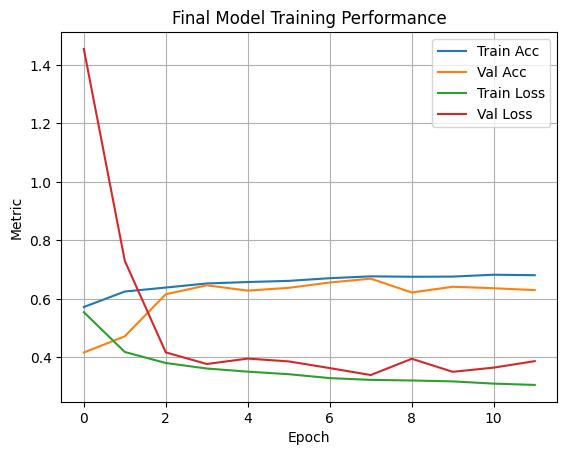

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_final.history['accuracy'], label='Train Acc')
plt.plot(history_final.history['val_accuracy'], label='Val Acc')
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title("Final Model Training Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.show()

## Transfer Learning with ResNet 1D architechture

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, kernel_size=3, stride=1, reg=0.001):
    shortcut = x  

    x = Conv1D(filters, kernel_size, padding='same', strides=stride,
               kernel_regularizer=l2(reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(reg))(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same',
                          kernel_regularizer=l2(reg))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (1000, 12)
inputs = Input(shape=input_shape)

x = Conv1D(32, 7, padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Stack residual blocks
x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(len(mlb.classes_), activation='sigmoid')(x)

resnet_model = Model(inputs, outputs)

In [ ]:
resnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history_resnet = resnet_model.fit(X_train, y_train_bin,
                                  validation_data=(X_test, y_test_bin),
                                  epochs=10,
                                  batch_size=64,
                                  callbacks=[early_stop, lr_schedule])

Epoch 1/10
  5/307 ━━━━━━━━━━━━━━━━━━━━ 1:06 219ms/step - accuracy: 0.7020 - loss: 0.2802

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet.history['accuracy'], label='Train Acc')
plt.plot(history_resnet.history['val_accuracy'], label='Val Acc')
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title("Final Model Training Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history_resnet' is not defined

# Random Forest

In [40]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [42]:

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
multi_rf = MultiOutputClassifier(rf)

multi_rf.fit(X_train_flat, y_train_bin)

MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=42))

In [43]:
from sklearn.metrics import classification_report

y_pred_rf = multi_rf.predict(X_test_flat)
print(classification_report(y_test_bin, y_pred_rf, target_names=mlb.classes_))

              precision    recall  f1-score   support

          CD       0.70      0.14      0.24       496
         HYP       0.00      0.00      0.00       262
          MI       0.52      0.04      0.08       550
        NORM       0.71      0.68      0.70       963
        STTC       0.58      0.03      0.05       521

   micro avg       0.70      0.27      0.39      2792
   macro avg       0.50      0.18      0.21      2792
weighted avg       0.58      0.27      0.31      2792
 samples avg       0.34      0.32      0.33      2792



/Users/grealish/anaconda3/envs/cnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/grealish/anaconda3/envs/cnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/grealish/anaconda3/envs/cnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [45]:
print("True:", y_test.iloc[0])
print("Predicted:", mlb.inverse_transform(np.array([y_pred_rf[0]]))[0])


True: ['NORM']
Predicted: ('NORM',)
